In [1]:
import pandas as pd
import mdtraj as md
import numpy as np
from numpy.random import seed
from numpy.random import shuffle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from __future__ import print_function
import seaborn as sns
from matplotlib.ticker import NullFormatter, MaxNLocator
from pandas.plotting import scatter_matrix
import matplotlib.ticker as ticker
#import plotly.graph_objects as go
import scipy as sp
from itertools import chain, combinations
import matplotlib as mpl
from matplotlib.lines import Line2D
from scipy import spatial
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
import scipy.stats as stats
#import statsmodels.stats.weightstats
from matplotlib import path
import matplotlib
from scipy.stats import probplot,shapiro, sem
#import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from scipy import stats
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,r2_score, mean_squared_error
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.linear_model import RidgeCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler

from matplotlib import cm
from collections import Counter
from numpy import linspace
#import umap.umap_ as umap
#import pylab
import os
#import PIL
from scipy.ndimage import gaussian_filter, uniform_filter1d

In [2]:
# import soursop
import afrc
import soursop
import MDAnalysis
import pandas as pd
import numpy as np
from soursop.sstrajectory import SSTrajectory
from Bio.PDB import *
from itertools import chain

In [3]:
print("MAKE SURE afrc_venv_ virtual environment is enabled with conda")
print("MAKE SURE python version is 3.9.18")
import sys
sys.version

MAKE SURE afrc_venv_ virtual environment is enabled with conda
MAKE SURE python version is 3.9.18


'3.9.18 (main, Jan 26 2024, 16:04:25) \n[GCC 8.5.0 20210514 (Red Hat 8.5.0-20)]'

# Some Functions

In [4]:
def RSA_based_fC(protein_var,protein_name,poly_id,
                       GW_moment_var,every_ith_snap,GW_every_ith_snap,radius_):
    x_total=[]
    y_total=[]
    if poly_id=='protein':
        protein_label=protein_name
        temp_protein=protein_var.copy()
        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)
        x_total=list(chain.from_iterable(x_total))
        y_total=list(chain.from_iterable(y_total))
        poly_var=protein_var.copy()
        protein_pro=poly_var[['ratio','RSA']].iloc[:every_ith_snap,:].copy()
        protein_pro['polymer_id']=np.repeat(protein_label,protein_pro.shape[0])
        del x_total, y_total, temp_protein
    else:
        return print('ERROR')

    GW_po=GW_moment_var[['ratio','RSA']][::GW_every_ith_snap].copy()
    GW_po['polymer_id']=np.repeat('GW',GW_po.shape[0])
    
    #calculate mean and stdev values (must keep same mean and stdev values)
    upto_snapshots=1000000
    GW_mean_ratio=np.mean(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_std_ratio=np.std(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_mean_RSA=np.mean(GW_po['RSA'].values[0:(upto_snapshots+1)])
    GW_std_RSA=np.std(GW_po['RSA'].values[0:(upto_snapshots+1)])
        
    combined_pro_po=pd.concat([GW_po,protein_pro],axis=0,ignore_index=True)
    combined_pro_po['stdd_ratio']=(combined_pro_po['ratio'].values-GW_mean_ratio)/(GW_std_ratio)
    combined_pro_po['stdd_RSA']=(combined_pro_po['RSA'].values-GW_mean_RSA)/(GW_std_RSA)
    po_x=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_RSA'].values
    po_y=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_ratio'].values
    pro_x=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_RSA'].values
    pro_y=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_ratio'].values
    
    GW_points=np.c_[po_x, po_y]
    protein_points=np.c_[pro_x, pro_y]    
    tree_GW=spatial.cKDTree(GW_points)
    tree_protein=spatial.cKDTree(protein_points)

    GW_not_in_range=[]
    j=0
    for point in GW_points:

        if not tree_protein.query_ball_point(point,radius_):
            GW_not_in_range.append(point)
        j+=1
        if j%100000==0:
            print(f'{j} GW snapshots completed')
                
    fC_by_distance=(GW_points.shape[0]-len(GW_not_in_range))/(GW_points.shape[0])
    return fC_by_distance    


In [5]:
def RSA_Rs_protein_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= 'RSA'
    y_variable=r'$R_s$'
    global fC_value, grid_protein, grid_GW

    testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]


    x_polmodel_GW.append(testeq_GW['RSA'].values)
    y_polmodel_GW.append(testeq_GW['ratio'].values)

    if second_obj=='protein':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)

        fC_value=RSA_based_fC(temp_protein,
                       protein_label,
                       second_obj,testeq_GW,
                       temp_protein.shape[0],
                       1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=1
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['RSA'].max()>max_x_val or testeq_GW['RSA'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(5.2,5))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 100
    nybins = 50
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.02#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=0.6#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    axTemperature.text(0.7,0.8,
                       '$f_C$= '+format(fC_value,'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)
    axTemperature.text(0.7,0.74,
                       '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    

    axTemp_legend=axTemperature.legend(fontsize=7,loc='upper right')

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Density',fontsize=12)
    axHisty.set_xlabel('Prob. Density',fontsize=12)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 



In [6]:
def protein_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= r'$R_g\left/R_g^{theta}\right.$' 
    y_variable=r'$R_s$'
    global grid_protein, grid_GW

    testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]

    GW_rg = testeq_GW['Rg2']**0.5
    GW_rg_mean = GW_rg.mean()
    GW_rg_by_rg_mean = GW_rg/GW_rg_mean
    testeq_GW['Rg/Rg_mean'] = GW_rg_by_rg_mean
    
    x_polmodel_GW.append(GW_rg_by_rg_mean)
    y_polmodel_GW.append(testeq_GW['ratio'].values)
    
    if second_obj=='protein':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein['Rg/Rg_theta'].values)
        y_total.append(temp_protein.ratio.values)

        # fC_value=RSA_based_fC(temp_protein,
        #                protein_label,
        #                second_obj,testeq_GW,
        #                temp_protein.shape[0],
        #                1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=3
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['Rg/Rg_mean'].max()>max_x_val or testeq_GW['Rg/Rg_mean'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(5.2,5))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 100
    nybins = 50
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.02#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=0.6#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    # axTemperature.text(0.7,0.8,
    #                    '$f_C$= '+format(fC_value,'0.3f'),
    #                   transform=axTemperature.transAxes,fontsize=8)
    axTemperature.text(0.7,0.74,
                       '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    

    axTemp_legend=axTemperature.legend(fontsize=7,loc='upper right')

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Density',fontsize=12)
    axHisty.set_xlabel('Prob. Density',fontsize=12)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 



# generate a dataframe connecting directory with seq_name in their property df

In [7]:
seq_name_AFRC = pd.read_csv('../holehouse_project/IDRome_shape_mean_size_mean_added.csv')

In [8]:
seq_name_dir_df = pd.read_csv('../larsen_paper_2023_compaction/seq_name_dir_df.csv')
seq_name_dir_df

,seq_name,seq_dir,protein_uniprot_id
0,H0YL14_1_46,IDROME_larsen/IDRome_v4/H0/YL/14/1_46,H0YL14
1,H0YL09_1_131,IDROME_larsen/IDRome_v4/H0/YL/09/1_131,H0YL09
2,H0YKK7_1_89,IDROME_larsen/IDRome_v4/H0/YK/K7/1_89,H0YKK7
3,H0YKK7_135_164,IDROME_larsen/IDRome_v4/H0/YK/K7/135_164,H0YKK7
4,H0YKK7_430_550,IDROME_larsen/IDRome_v4/H0/YK/K7/430_550,H0YKK7
...,...,...,...
28053,A3QJZ6_111_153,IDROME_larsen/IDRome_v4/A3/QJ/Z6/111_153,A3QJZ6
28054,A3QJZ7_106_152,IDROME_larsen/IDRome_v4/A3/QJ/Z7/106_152,A3QJZ7
28055,A3KN83_1001_1044,IDROME_larsen/IDRome_v4/A3/KN/83/1001_1044,A3KN83
28056,A3KN83_1_250,IDROME_larsen/IDRome_v4/A3/KN/83/1_250,A3KN83


# write function

In [9]:
def compute_3dplot_from_seq_name(seq_name):
    global protein_df
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    protein_rg_theta = seq_name_AFRC[seq_name_AFRC.seq_name==seq_name].AFRC_mean_rg_theta.values[0]
    #convert nm to angstrom for lindorff-larsen data
    protein_rg_by_rg_theta = (np.load(f'{example_protein_dir}/rg.npy')*10)/protein_rg_theta
    protein_df = pd.DataFrame(zip(np.load(f'{example_protein_dir}/rg.npy')**2,
                                 protein_rg_by_rg_theta),columns=['Rg2','Rg/Rg_theta']).copy()
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
    return protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

In [10]:
def RSA_Rs_compute_3dplot_from_seq_name(seq_name):
    global protein_df
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_df_moments = pd.DataFrame(md.principal_moments(t),columns=['R3','R2','R1']).iloc[10:,:].copy()
    t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
    t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
    t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
    protein_df = t_df_moments[['RSA']].copy()
    del t_df_moments
    protein_df['Rg2'] = np.load(f'{example_protein_dir}/rg.npy')**2
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
    return RSA_Rs_protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

In [11]:
def load_trajectory(seq_name):
    #https://soursop.readthedocs.io/en/latest/usage/overview.html
    from soursop.sstrajectory import SSTrajectory
    global t_md, t_soursop,ree
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t_md = md.load(f'../larsen_paper_2023_compaction/{example_protein_dir}/traj.xtc', 
                   top=f'../larsen_paper_2023_compaction/{example_protein_dir}/top.pdb')
    t_soursop = SSTrajectory(f'../larsen_paper_2023_compaction/{example_protein_dir}/traj.xtc',
                             f'../larsen_paper_2023_compaction/{example_protein_dir}/top.pdb')
    ree = np.load(f'../larsen_paper_2023_compaction/{example_protein_dir}/ete.npy')
    ProtObj = t_soursop.proteinTrajectoryList[0]
    return ProtObj


In [12]:
#Rij is from lindorff-larsen
def Rij(traj):
    pairs = traj.top.select_pairs('all','all')
    d = md.compute_distances(traj,pairs)
    nres = traj.n_atoms
    ij = np.arange(2,nres,1)
    diff = [x[1]-x[0] for x in pairs]
    dij = np.empty(0)
    for i in ij:
        dij = np.append(dij,np.sqrt((d[:,diff==i]**2).mean().mean()))
    f = lambda x,R0,v : R0*np.power(x,v)
    popt, pcov = curve_fit(f,ij[ij>5],dij[ij>5],p0=[.4,.5])
    nu = popt[1]
    nu_err = pcov[1,1]**0.5
    R0 = popt[0]
    R0_err = pcov[0,0]**0.5
    return ij,dij,nu,nu_err,R0,R0_err

def calculate_nu_KLL_from_seq_name(seq_name, start_residue, end_residue):
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name == seq_name].seq_dir.values[0]
    t_md = md.load(f'../larsen_paper_2023_compaction/{example_protein_dir}/traj.xtc', 
                   top=f'../larsen_paper_2023_compaction/{example_protein_dir}/top.pdb')
    # Skipping the first 10 frames
    t_md = t_md[10:]
    subsequence_indices = t_md.topology.select(f'residue {start_residue-1} to {end_residue-1}')
    
    subsequence_traj = t_md.atom_slice(subsequence_indices)

    ij, dij, nu, nu_err, R0, R0_err = Rij(subsequence_traj)
    return nu, nu_err

#original lindorff-larsen code,keeping as reference (Rij is original function from their github)
# def calculate_nu_KLL(seq_name):
#     example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
#     t_md = md.load(f'../larsen_paper_2023_compaction/{example_protein_dir}/traj.xtc', 
#                    top=f'../larsen_paper_2023_compaction/{example_protein_dir}/top.pdb')
#     ij,dij,nu,nu_err,R0,R0_err = Rij(t_md)
#     return nu

# def Rij(traj):
#     pairs = traj.top.select_pairs('all','all')
#     d = md.compute_distances(traj,pairs)
#     nres = traj.n_atoms
#     ij = np.arange(2,nres,1)
#     diff = [x[1]-x[0] for x in pairs]
#     dij = np.empty(0)
#     for i in ij:
#         dij = np.append(dij,np.sqrt((d[:,diff==i]**2).mean().mean()))
#     f = lambda x,R0,v : R0*np.power(x,v)
#     popt, pcov = curve_fit(f,ij[ij>5],dij[ij>5],p0=[.4,.5])
#     nu = popt[1]
#     nu_err = pcov[1,1]**0.5
#     R0 = popt[0]
#     R0_err = pcov[0,0]**0.5
#     return ij,dij,nu,nu_err,R0,R0_err

In [13]:
#master_df = master_df.reset_index(drop=True).copy()

# use  pyconformap shape vs size

In [14]:
exec(open("../larsen_paper_2023_compaction/pyconformap_modified.py").read())
def generate_2d_map(seq_name):
    location_of_files = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]    
    rg2_value = np.load(location_of_files+'/rg.npy')**2
    ree2_value = np.load(location_of_files+'/ete.npy')**2
    pd.DataFrame(zip(rg2_value,ree2_value),columns=['Rg2','Ree2']).to_csv(seq_name+'.csv',index=False)
    map_2d_seq_name = PyConforMap(seq_name+'.csv')
    map_2d_seq_name.plot_protein_against_GW(seq_name+'.csv')
    os.remove(seq_name+'.csv')
    return 

# combine the df


In [17]:
seq_name_fluctations = pd.read_csv('../larsen_paper_2023_compaction/HPC_computed_fC_values_all.csv').set_index('seq_name_list')
seq_stdev = pd.read_csv('../holehouse_project/IDRome_Rg_Rs_RSA_stdev.csv').set_index('seq_name')
seq_ALBATROSS = pd.read_csv('../holehouse_project/IDRome_with_ALBATROSS_calculations.csv').set_index('seq_name')
seq_ranges = pd.read_csv('../holehouse_project/IDRome_Rg_Rs_RSA_range.csv').set_index('seq_name')
seq_Rs_RSA_min_max = pd.read_csv('../holehouse_project/IDRome_Rs_RSA_min_max.csv').set_index('seq_name')
seq_Rs_12_frac = pd.read_csv('../holehouse_project/IDRome_Rs_frac_greater_than_12.csv').set_index('seq_name')

# the bounded_frac_size_shape is only for size-shape (through pyconformap_modified)


#add fP to the property df
seq_name_AFRC['fP'] = [seq.count('P')/len(seq) for seq in seq_name_AFRC.fasta.values]


seq_name_AFRC['net_charge'] = [(seq.count('K')+seq.count('R')-seq.count('D')-seq.count('E'))/len(seq) for seq in seq_name_AFRC.fasta.values]
seq_name_AFRC['fpos'] = [(seq.count('K')+seq.count('R'))/len(seq) for seq in seq_name_AFRC.fasta.values]
seq_name_AFRC['fneg'] = [(seq.count('D')+seq.count('E'))/len(seq) for seq in seq_name_AFRC.fasta.values]
seq_name_AFRC['faliphatic'] = [(seq.count('I')+seq.count('L')+seq.count('M')+seq.count('V'))/len(seq) for seq in seq_name_AFRC.fasta.values]

idrome_prop_flucs = pd.concat([seq_name_AFRC.set_index('seq_name'),
           seq_name_fluctations[['fC_shape_shape',
                                 'fA_shape_shape',
                                 'fC_size_shape',
                                 'fA_size_shape',
                                 'bounded_frac_size_shape']],
                              seq_stdev[['Rg_std','Rs_std','RSA_std']],
                              seq_ALBATROSS[['albatross_Rg','albatross_Rg_scaled','albatross_Ree','albatross_Ree_scaled',
                                             'albatross_scaling_exponent']],
                              seq_ranges[['Rg_range','Rs_range','RSA_range']],
                              seq_Rs_RSA_min_max[['Rs_min','Rs_max','RSA_min','RSA_max']],
                              seq_Rs_12_frac[['Rs_frac']]],
          axis=1).reset_index().rename(columns={'index':'seq_name'}).copy()

del seq_name_fluctations, seq_name_AFRC, seq_stdev, seq_ALBATROSS, seq_Rs_RSA_min_max,seq_Rs_12_frac
idrome_prop_flucs

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,albatross_Ree_scaled,albatross_scaling_exponent,Rg_range,Rs_range,RSA_range,Rs_min,Rs_max,RSA_min,RSA_max,Rs_frac
0,A0A024RBG1_145_181,A0A024RBG1,37,0.558,10.284649,6.304027,0.933961,0.225950,1.606561,3.843011,...,4.251985,0.578297,0.790029,7.039022,0.537698,0.394069,13.359064,0.020020,0.919532,0.005
1,A0A075B6T7_1_32,A0A075B6T7,32,0.525,10.092351,6.114494,0.901807,0.212670,1.448141,3.390487,...,3.321804,0.498650,0.756501,7.359276,0.538843,0.362843,12.440695,0.005640,0.916947,0.002
2,A0A087WTH1_1_67,A0A087WTH1,67,0.532,10.160125,6.069995,0.822738,0.199126,2.243991,5.283533,...,5.788718,0.544833,1.185494,7.414943,0.500908,0.141260,15.066551,0.009369,0.898853,0.015
3,A0A087WTH5_1_132,A0A087WTH5,132,0.496,10.049124,6.150972,0.798438,0.188978,3.034005,7.119714,...,7.813105,0.504434,1.620033,8.038966,0.485090,0.126127,16.653733,0.005293,0.864358,0.036
4,A0A087WV53_1_46,A0A087WV53,46,0.567,10.212765,6.439589,0.882210,0.214786,1.882622,4.607908,...,4.962079,0.566668,0.945399,6.813072,0.499202,0.233267,13.580518,0.032299,0.866482,0.012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28053,Q9Y6Z4_1_181,Q9Y6Z4,181,0.493,10.006512,5.748098,0.799905,0.210890,3.791956,8.607822,...,9.803478,0.534929,2.045043,7.521686,0.492647,0.095092,15.142073,0.011525,0.893606,0.017
28054,Q9Y6Z5_1_254,Q9Y6Z5,254,0.528,9.830710,6.153759,0.896173,0.221422,4.586832,10.808776,...,10.582268,0.504626,2.664859,7.982766,0.519563,0.295461,17.727406,0.016098,0.887311,0.036
28055,Q9Y6Z7_1_109,Q9Y6Z7,109,0.546,10.025622,6.175505,0.935857,0.216970,3.011145,7.113405,...,7.863577,0.570739,1.685618,7.465008,0.516141,0.119394,15.193279,0.021437,0.911143,0.013
28056,W6CW81_1_113,W6CW81,113,0.519,10.084249,6.191149,0.843169,0.193880,2.943990,6.975229,...,7.289317,0.541635,1.597735,7.462810,0.493407,0.061003,14.613526,0.021912,0.902681,0.022


In [18]:
idrome_prop_flucs.columns

Index(['seq_name', 'UniProt_ID', 'N', 'nu', 'SPR', 'ete2_Rg2', 'S', 'Delta',
       'Rg/nm', 'Ree/nm', 'Rh/nm', 'fK', 'fR', 'fE', 'fD', 'faro',
       'mean_lambda', 'shd', 'scd', 'kappa', 'fcr', 'ncpr', 'fasta',
       'is_btw_folded', 'is_nterm', 'is_cterm', 'is_idp', 'first', 'last',
       'N_FL', 'protein_name', 'gene_name', 'QCDpred', 'z_delta_+-',
       'z_omega_pi', 'z_omega_+', 'z_omega_-', 'z_omega_h', 'fdomain',
       'nu_svr', 'SPR_svr', 'AFRC_mean_rg_theta', 'rg_rg_theta_mean',
       'mean_inst_ratio', 'mean_RSA', 'fP', 'net_charge', 'fpos', 'fneg',
       'faliphatic', 'fC_shape_shape', 'fA_shape_shape', 'fC_size_shape',
       'fA_size_shape', 'bounded_frac_size_shape', 'Rg_std', 'Rs_std',
       'RSA_std', 'albatross_Rg', 'albatross_Rg_scaled', 'albatross_Ree',
       'albatross_Ree_scaled', 'albatross_scaling_exponent', 'Rg_range',
       'Rs_range', 'RSA_range', 'Rs_min', 'Rs_max', 'RSA_min', 'RSA_max',
       'Rs_frac'],
      dtype='object')

### DO NOT RUN the immediately below cell

In [16]:
#DO NOT run this cell
#these FOUR IDR simulations have low snapshots (<1000)
# %%time
# for seq_dir in seq_name_dir_df.seq_dir.values:
#     if np.load(seq_dir+'/rg.npy').shape[0]!=1000:
#         print(seq_name_dir_df[seq_name_dir_df.seq_dir==seq_dir].seq_name, np.load(seq_dir+'/rg.npy').shape[0])

3703    Q53SF7_218_1128
Name: seq_name, dtype: object 500
11700    Q7Z2Y5_341_1224
Name: seq_name, dtype: object 420
23881    Q9Y2W1_1_611
Name: seq_name, dtype: object 100
27365    Q9BXT5_1_968
Name: seq_name, dtype: object 100
CPU times: user 3.77 s, sys: 2.96 s, total: 6.73 s
Wall time: 14min 48s


In [19]:
#drop these FOUR IDR simulations because of low snapshots #
seq_name_dir_df = seq_name_dir_df[~seq_name_dir_df.seq_name.isin(['Q53SF7_218_1128',
                                             'Q7Z2Y5_341_1224',
                                             'Q9Y2W1_1_611',
                                             'Q9BXT5_1_968'])].copy()

idrome_prop_flucs = idrome_prop_flucs[~idrome_prop_flucs.seq_name.isin(['Q53SF7_218_1128',
                                             'Q7Z2Y5_341_1224',
                                             'Q9Y2W1_1_611',
                                             'Q9BXT5_1_968'])].copy()

## additional functions for visualization

In [20]:
print('NOTE: this is specifically for protamine simulations - will require some editing for others')
def compute_kmer_data_from_all_atom_simulation(seq_name,k_frac,sim_num):
    
    
    traj = md.load(f'/project/hshadman/hshadman/protamine_simulation/protamine_bull/explicit_solvent/more_nosalt_runs/explicit_continued_from_implicit/Rg_Ree/combined_{sim_num}.crd',
                   top=f'/project/hshadman/hshadman/protamine_simulation/protamine_bull/explicit_solvent/more_nosalt_runs/explicit_continued_from_implicit/Rg_Ree/stripped_{sim_num}.bull_box_{sim_num}.prmtop')


    topology = md.load_topology(f'/project/hshadman/hshadman/protamine_simulation/protamine_bull/explicit_solvent/more_nosalt_runs/explicit_continued_from_implicit/Rg_Ree/stripped_{sim_num}.bull_box_{sim_num}.prmtop')

    # Initialize an empty list to hold the sequence
    protein_sequence = []
    
    # Loop through each residue in the topology and get the residue name
    for residue in topology.residues:
        if residue.is_protein:  # Check if the residue is part of a protein
            protein_sequence.append(residue.name)
    
    # Convert three-letter codes to one-letter codes using a predefined dictionary
    three_to_one = {
        'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
        'GLU': 'E', 'GLN': 'Q', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
        'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
        'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
    }
    
    # Map three-letter codes to one-letter codes
    protein_sequence_one_letter = [three_to_one[res] for res in protein_sequence if res in three_to_one]
    
    # Join the sequence into a single string
    protein_sequence_str = ''.join(protein_sequence_one_letter)
    
    
    fasta_sequence = protein_sequence_str

    # for PROTAMINE make sure that it has 100000 frames and drop if it has extra
    if len(traj) > 100000:
        traj = traj[:100000]  # Truncate to the first 100000 frames if more are present

    # Select the last 40000 frames from the trajectory
    traj = traj[-40000:]    
    
    # Set the subsequence length k (replace 4 with your desired value)
    n_residues = traj.topology.n_residues
    k = round(traj.topology.n_residues/k_frac)

    complete_protein_rgyr = np.mean(md.compute_rg(traj))
    first_bead_index = traj.topology.select(f"residue {0} and name CA")[0]
    last_bead_index = traj.topology.select(f"residue {n_residues-1} and name CA")[0]
    end_to_end_distances = md.compute_distances(traj, [[first_bead_index, last_bead_index]])
    end_to_end_distances = end_to_end_distances.flatten()
    complete_protein_ete = end_to_end_distances
    complete_protein_inst_ratio = np.mean((complete_protein_ete**2)/(complete_protein_rgyr**2))
    
    complete_protein_moments = pd.DataFrame(md.principal_moments(traj),columns=['R3','R2','R1']).copy()
    complete_protein_moments['asphericity']=complete_protein_moments.R1.values-(0.5*(complete_protein_moments.R2.values+complete_protein_moments.R3.values))
    complete_protein_moments['acylindricity']=complete_protein_moments.R2.values-complete_protein_moments.R3.values
    complete_protein_moments['RSA']=(complete_protein_moments.asphericity.values**2+(0.75*complete_protein_moments.acylindricity.values**2))/(complete_protein_moments.R1.values+complete_protein_moments.R2.values+complete_protein_moments.R3.values)**2
    complete_protein_RSA = np.mean(complete_protein_moments['RSA'].values)
    
    #AFRC
    complete_protein_afrc_init = afrc.AnalyticalFRC(fasta_sequence)
    complete_protein_rg_theta_mean = complete_protein_afrc_init.get_mean_radius_of_gyration()
    complete_protein_rg_rg_theta_mean = np.mean((10*md.compute_rg(traj))/complete_protein_rg_theta_mean)

    del first_bead_index, last_bead_index, end_to_end_distances
    j = 0
    # Iterate through each subsequence of k residues
    for start_res in range(1, n_residues - k + 2):  # Ensures we don't go out of bounds
        # Select k consecutive residues
        selection_string = f"residue {start_res-1} to {start_res + k - 2}"  # MDTraj is zero-indexed
        subsequence_indices = traj.topology.select(selection_string)
        
        fasta_slice = fasta_sequence[(start_res-1):(start_res + k - 1)]
        running_df = pd.DataFrame(np.repeat(fasta_slice,traj.n_frames),columns=['fasta_sequence'])
        running_df['start_res_zeroindex'] = np.repeat(start_res-1,traj.n_frames)
        running_df['end_res_zeroindex'] = np.repeat(start_res + k - 2,traj.n_frames)
        running_df['full_protein_fasta'] = np.repeat(fasta_sequence,traj.n_frames)
        
        running_df['full_protein_rgyr'] = np.repeat(complete_protein_rgyr,traj.n_frames)
        running_df['full_protein_inst_ratio'] = np.repeat(complete_protein_inst_ratio,traj.n_frames)
        running_df['full_protein_RSA'] = np.repeat(complete_protein_RSA,traj.n_frames)
        running_df['full_protein_rg_rg_theta_mean'] = np.repeat(complete_protein_rg_rg_theta_mean,traj.n_frames)
        
        running_df['sim'] = np.repeat(sim_num,traj.n_frames)
        running_df['seq_name'] = np.repeat(seq_name,traj.n_frames)
        # Create a trajectory slice for the selected subsequence
        subsequence_traj = traj.atom_slice(subsequence_indices)
        
        # Calculate the radius of gyration for the subsequence over all remaining frames
        rgyr = md.compute_rg(subsequence_traj)
        running_df['Rg/nm'] = rgyr
        
        # Select indices for the first and last bead in the subsequence for end-to-end distance calculation
        first_bead_index = traj.topology.select(f"residue {start_res-1} and name CA")[0]
        last_bead_index = traj.topology.select(f"residue {start_res + k - 2} and name CA")[0]
    
        # Calculate end-to-end distances for the subsequence over all remaining frames
        end_to_end_distances = md.compute_distances(traj, [[first_bead_index, last_bead_index]])
        end_to_end_distances = end_to_end_distances.flatten()
        running_df['ete'] = end_to_end_distances
        running_df['inst_ratio'] = (running_df['ete'].values**2)/(running_df['Rg/nm'].values**2)
        
        t_df_moments = pd.DataFrame(md.principal_moments(subsequence_traj),columns=['R3','R2','R1']).copy()
        t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
        t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
        t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
        running_df['RSA'] = t_df_moments['RSA'].values

        #AFRC
        afrc_init = afrc.AnalyticalFRC(fasta_slice)
        rg_theta_mean = afrc_init.get_mean_radius_of_gyration()
        running_df['AFRC_mean_rg_theta'] = np.repeat(rg_theta_mean,traj.n_frames)
        running_df['rg_rg_theta_mean'] = (10*running_df['Rg/nm'].values)/running_df['AFRC_mean_rg_theta'].values
        
        if j == 0:
            master_df = running_df.copy()
        elif j>0:
            master_df = pd.concat([master_df,running_df],axis=0).copy()
        del running_df, t_df_moments
        print(f"residue {start_res-1} to {start_res + k - 2} done")
        j+=1
    print('ALL DONE')    
    return master_df

NOTE: this is specifically for protamine simulations - will require some editing for others


In [21]:
def compute_kmer_data_from_seq_name(seq_name,k_frac):
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    
    traj = md.load(f'../larsen_paper_2023_compaction/{example_protein_dir}/traj.xtc',
                   top=f'../larsen_paper_2023_compaction/{example_protein_dir}/top.pdb')
    
    fasta_sequence = idrome_prop_flucs[idrome_prop_flucs.seq_name==seq_name].fasta.values[0]
    
    # Skipping the first 10 frames
    traj = traj[10:]    
    
    # Set the subsequence length k (replace 4 with your desired value)
    n_residues = traj.topology.n_residues
    k = round(traj.topology.n_residues/k_frac)

    complete_protein_rgyr = np.mean(md.compute_rg(traj))
    complete_protein_nu = calculate_nu_KLL_from_seq_name(seq_name, 1, n_residues)[0]
    complete_protein_nu_err = calculate_nu_KLL_from_seq_name(seq_name, 1, n_residues)[1]
    first_bead_index = traj.topology.select(f"residue {0}")[0]
    last_bead_index = traj.topology.select(f"residue {n_residues - 1}")[0]    
    end_to_end_distances = md.compute_distances(traj, [[first_bead_index, last_bead_index]])
    end_to_end_distances = end_to_end_distances.flatten()
    complete_protein_ete = end_to_end_distances
    complete_protein_inst_ratio = np.mean((complete_protein_ete**2)/(complete_protein_rgyr**2))
    
    complete_protein_moments = pd.DataFrame(md.principal_moments(traj),columns=['R3','R2','R1']).copy()
    complete_protein_moments['asphericity']=complete_protein_moments.R1.values-(0.5*(complete_protein_moments.R2.values+complete_protein_moments.R3.values))
    complete_protein_moments['acylindricity']=complete_protein_moments.R2.values-complete_protein_moments.R3.values
    complete_protein_moments['RSA']=(complete_protein_moments.asphericity.values**2+(0.75*complete_protein_moments.acylindricity.values**2))/(complete_protein_moments.R1.values+complete_protein_moments.R2.values+complete_protein_moments.R3.values)**2
    complete_protein_RSA = np.mean(complete_protein_moments['RSA'].values)    

    #AFRC
    complete_protein_afrc_init = afrc.AnalyticalFRC(fasta_sequence)
    complete_protein_rg_theta_mean = complete_protein_afrc_init.get_mean_radius_of_gyration()
    complete_protein_rg_rg_theta_mean = np.mean((10*md.compute_rg(traj))/complete_protein_rg_theta_mean)

    
    j = 0
    # Iterate through each subsequence of k residues
    for start_res in range(1, n_residues - k + 2):  # Ensures we don't go out of bounds
        # Select k consecutive residues
        selection_string = f"residue {start_res-1} to {start_res + k - 2}"  # MDTraj is zero-indexed
        subsequence_indices = traj.topology.select(selection_string)
        
        fasta_slice = fasta_sequence[(start_res-1):(start_res + k - 1)]
        running_df = pd.DataFrame(np.repeat(fasta_slice,traj.n_frames),columns=['fasta_sequence'])
        running_df['start_res_zeroindex'] = np.repeat(start_res-1,traj.n_frames)
        running_df['end_res_zeroindex'] = np.repeat(start_res + k - 2,traj.n_frames)
        running_df['full_protein_fasta'] = np.repeat(fasta_sequence,traj.n_frames)

        running_df['full_protein_rgyr'] = np.repeat(complete_protein_rgyr,traj.n_frames)
        running_df['full_protein_nu_recompute'] = np.repeat(complete_protein_nu,traj.n_frames)
        running_df['full_protein_nu_recompute_err'] = np.repeat(complete_protein_nu_err,traj.n_frames)
        running_df['full_protein_ratio'] = np.repeat(complete_protein_inst_ratio,traj.n_frames)
        running_df['full_protein_RSA'] = np.repeat(complete_protein_RSA,traj.n_frames)
        running_df['full_protein_rg_rg_theta_mean'] = np.repeat(complete_protein_rg_rg_theta_mean,traj.n_frames)
        
        running_df['seq_name'] = np.repeat(seq_name,traj.n_frames)
        # Create a trajectory slice for the selected subsequence
        subsequence_traj = traj.atom_slice(subsequence_indices)
        
        # Calculate the radius of gyration for the subsequence over all remaining frames
        rgyr = md.compute_rg(subsequence_traj)
        running_df['Rg/nm'] = rgyr

        #calculate nu
        subsequence_nu = calculate_nu_KLL_from_seq_name(seq_name, start_res, start_res + k - 1)[0]
        subsequence_nu_err = calculate_nu_KLL_from_seq_name(seq_name, start_res, start_res + k - 1)[1]
        running_df['nu_recompute'] = np.repeat(subsequence_nu,traj.n_frames)
        running_df['nu_recompute_err'] = np.repeat(subsequence_nu_err,traj.n_frames)
        
        # Select indices for the first and last bead in the subsequence for end-to-end distance calculation
        first_bead_index = traj.topology.select(f"residue {start_res-1}")[0]
        last_bead_index = traj.topology.select(f"residue {start_res + k - 2}")[0]
    
        # Calculate end-to-end distances for the subsequence over all remaining frames
        end_to_end_distances = md.compute_distances(traj, [[first_bead_index, last_bead_index]])
        end_to_end_distances = end_to_end_distances.flatten()
        running_df['ete'] = end_to_end_distances
        running_df['inst_ratio'] = (running_df['ete'].values**2)/(running_df['Rg/nm'].values**2)
        
        t_df_moments = pd.DataFrame(md.principal_moments(subsequence_traj),columns=['R3','R2','R1']).copy()
        t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
        t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
        t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
        running_df['RSA'] = t_df_moments['RSA'].values

        #AFRC
        afrc_init = afrc.AnalyticalFRC(fasta_slice)
        rg_theta_mean = afrc_init.get_mean_radius_of_gyration()
        running_df['AFRC_mean_rg_theta'] = np.repeat(rg_theta_mean,traj.n_frames)
        running_df['rg_rg_theta_mean'] = (10*running_df['Rg/nm'].values)/running_df['AFRC_mean_rg_theta'].values
        
        if j == 0:
            master_df = running_df.copy()
        elif j>0:
            master_df = pd.concat([master_df,running_df],axis=0).copy()
        del running_df, t_df_moments
        print(f"residue {start_res-1} to {start_res + k - 2} done")
        j+=1
    print('ALL DONE')    
    return master_df

In [22]:
def plot_protein_composition(seq_name):
    protein_sequence = idrome_prop_flucs[idrome_prop_flucs.seq_name==seq_name].fasta.values[0]
    # Define the groups and their respective amino acids
    groups = {
        'Negative (E/D)': ['E', 'D'],
        'Positive (R/K)': ['R', 'K'],
        'Proline (P)': ['P'],
        'Aromatic (Y/F/W)': ['Y', 'F', 'W'],
        'Aliphatic (I/L/M/V)': ['I', 'L', 'M', 'V'],
        'Uncategorized (S/G/A/T/Q/N/H/C)': ['S','G','A','T','Q','N','H','C']
    }
    
    # Colors corresponding to each group, including 'Uncategorized'
    colors = {
        'Negative (E/D)': 'red',
        'Positive (R/K)': 'blue',
        'Proline (P)': 'purple',
        'Aromatic (Y/F/W)': 'yellow',
        'Aliphatic (I/L/M/V)': 'grey',
        'Uncategorized (S/G/A/T/Q/N/H/C)': 'lightgrey'
    }
    
    # Count the frequency of each group in the sequence
    group_count = {group: 0 for group in groups}
    categorized_count = 0  # Track categorized residues to find uncategorized ones

    for aa in protein_sequence:
        found = False
        for group, aas in groups.items():
            if aa in aas:
                group_count[group] += 1
                categorized_count += 1
                found = True
                break
        if not found:
            group_count.setdefault('Uncategorized', 0)
            group_count['Uncategorized'] += 1
    
    # Prepare data for the pie chart
    labels = [group for group in group_count if group_count[group] > 0]
    sizes = [group_count[group] for group in labels]
    plot_colors = [colors[label] for label in labels]
    
    # Create pie chart
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct=lambda pct: f"{pct:.1f}%", startangle=90, colors=plot_colors)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

def plot_protein_composition_subchain(seq_name,start_index,end_index):
    protein_sequence = idrome_prop_flucs[idrome_prop_flucs.seq_name==seq_name].fasta.values[0][start_index:(end_index+1)]
    # Define the groups and their respective amino acids
    groups = {
        'Negative (E/D)': ['E', 'D'],
        'Positive (R/K)': ['R', 'K'],
        'Proline (P)': ['P'],
        'Aromatic (Y/F/W)': ['Y', 'F', 'W'],
        'Aliphatic (I/L/M/V)': ['I', 'L', 'M', 'V'],
        'Uncategorized (S/G/A/T/Q/N/H/C)': ['S','G','A','T','Q','N','H','C']
    }
    
    # Colors corresponding to each group, including 'Uncategorized'
    colors = {
        'Negative (E/D)': 'red',
        'Positive (R/K)': 'blue',
        'Proline (P)': 'purple',
        'Aromatic (Y/F/W)': 'yellow',
        'Aliphatic (I/L/M/V)': 'grey',
        'Uncategorized (S/G/A/T/Q/N/H/C)': 'lightgrey'
    }
    
    # Count the frequency of each group in the sequence
    group_count = {group: 0 for group in groups}
    categorized_count = 0  # Track categorized residues to find uncategorized ones

    for aa in protein_sequence:
        found = False
        for group, aas in groups.items():
            if aa in aas:
                group_count[group] += 1
                categorized_count += 1
                found = True
                break
        if not found:
            group_count.setdefault('Uncategorized', 0)
            group_count['Uncategorized'] += 1
    
    # Prepare data for the pie chart
    labels = [group for group in group_count if group_count[group] > 0]
    sizes = [group_count[group] for group in labels]
    plot_colors = [colors[label] for label in labels]
    
    # Create pie chart
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct=lambda pct: f"{pct:.1f}%", startangle=90, colors=plot_colors)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


In [23]:
def assign_properties(residue):
    properties = {
        'negative': ['E', 'D'],
        'positive': ['R', 'K'],
        'apolar': ['Y', 'F','A', 'W','I', 'L', 'M', 'V','P','G','C'],
        'polar': ['S','T','Q','N','H']
    }
    colors = {
        'negative': 'red',
        'positive': 'blue',
        'apolar': 'yellow',
        'polar': 'white'  # Visibility adjustment with black edge
    }
    size = 0
    color = 'black'
    for prop, residues in properties.items():
        if residue in residues:
            color = colors[prop]
            size = 80  # Adjust size for visual distinction
            break
    return color, size
def subchain_Rg_plot(df,figwidth,figheight):
    # Calculate the midpoint for plotting and the properties for each midpoint
    df['mid_residue'] = (df['start_res_zeroindex'] + df['end_res_zeroindex']) // 2
    df[['color', 'size']] = df.apply(lambda row: assign_properties(row['full_protein_fasta'][row['mid_residue']]),
                                     axis=1, result_type='expand')
    
    # Group by 'mid_residue' to calculate mean, standard deviation and get the most common color and size
    stats_rg = df.groupby('mid_residue').agg({
        'Rg/nm': ['mean', 'std'],
        'color': lambda x: x.mode()[0],
        'size': lambda x: x.mode()[0]
    }).reset_index()
    
    # Flatten the MultiIndex
    stats_rg.columns = ['mid_residue', 'mean', 'std', 'color', 'size']

    fig, ax = plt.subplots(figsize=(figwidth, figheight))
    
    # Plotting
    ax.plot(stats_rg['mid_residue'], stats_rg['mean'], color='black', zorder=1)
    ax.fill_between(stats_rg['mid_residue'], 
                     stats_rg['mean'] - (stats_rg['std']/2), 
                     stats_rg['mean'] + (stats_rg['std']/2), 
                     color='gray', alpha=0.2, zorder=1)
    global_var = df.full_protein_rgyr.unique()[0]
    if global_var>=np.min(ax.get_ylim()) and global_var<=np.max(ax.get_ylim()):
        ax.axhline(y=global_var, color='black', linestyle='--')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold')
    else:
        fig.text(0.12, 0.879, f'Global <$R_g$> = {format(global_var, "0.2f")} nm',
                 fontsize=12, verticalalignment='bottom', horizontalalignment='left')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold',pad = 22)
    
    # Adjust scatter plot to use different sizes and colors with higher zorder
    for i, row in stats_rg.iterrows():
        ax.scatter(row['mid_residue'], row['mean'], color=row['color'], s=row['size'], zorder=2,edgecolors='black', linewidths=1)
    
    ax.set_xlabel('Residue', fontsize=12)
    ax.set_ylabel('Local <$R_g$> (nm)', fontsize=12)
    
    
    # Customizing the plot border thickness
    for spine in ['top', 'left', 'right', 'bottom']:
        ax.spines[spine].set_linewidth(1.2)
    
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=10, width=0.75, pad=2)
    ax.tick_params(axis='both', which='minor', width=0.6)
    
    # Create custom legend with circles and edge color for white patch
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Negative (E/D)', markersize=10, markerfacecolor='red',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Positive (R/K)', markersize=10, markerfacecolor='blue',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Apolar (Y/F/A/W/I/L/M/V/P/G/C)', markersize=10, markerfacecolor='yellow',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Polar (S/T/Q/N/H)', markersize=10, markerfacecolor='white',
              markeredgewidth=1, markeredgecolor='black')  
    ]
    
    # Adding the legend with the custom entries
    ax.legend(handles=legend_elements, loc=(1.01,0.6))
    return 



In [24]:
def subchain_Rs_plot(df,figwidth,figheight):
    # Calculate the midpoint for plotting and the properties for each midpoint
    df['mid_residue'] = (df['start_res_zeroindex'] + df['end_res_zeroindex']) // 2
    df[['color', 'size']] = df.apply(lambda row: assign_properties(row['full_protein_fasta'][row['mid_residue']]),
                                     axis=1, result_type='expand')
    
    # Group by 'mid_residue' to calculate mean, standard deviation and get the most common color and size
    stats_rs = df.groupby('mid_residue').agg({
        'inst_ratio': ['mean', 'std'],
        'color': lambda x: x.mode()[0],
        'size': lambda x: x.mode()[0]
    }).reset_index()
    
    # Flatten the MultiIndex
    stats_rs.columns = ['mid_residue', 'mean', 'std', 'color', 'size']
    
    fig, ax = plt.subplots(figsize=(figwidth,figheight))
    
    # Plotting
    ax.plot(stats_rs['mid_residue'], stats_rs['mean'], color='black', zorder=1)
    ax.fill_between(stats_rs['mid_residue'], 
                     stats_rs['mean'] - (stats_rs['std']/2), 
                     stats_rs['mean'] + (stats_rs['std']/2), 
                     color='gray', alpha=0.2, zorder=1)

    global_var = df.full_protein_inst_ratio.unique()[0]
    if global_var>=np.min(ax.get_ylim()) and global_var<=np.max(ax.get_ylim()):
        ax.axhline(y=global_var, color='black', linestyle='--')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold')
    else:
        fig.text(0.12, 0.879, f'Global <$R_s$> = {format(global_var, "0.2f")}',
                 fontsize=12, verticalalignment='bottom', horizontalalignment='left')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold',pad = 22)
    
    # Adjust scatter plot to use different sizes and colors with higher zorder
    for i, row in stats_rs.iterrows():
        ax.scatter(row['mid_residue'], row['mean'], color=row['color'], s=row['size'], zorder=2,edgecolors='black', linewidths=1)
    
    ax.set_xlabel('Residue', fontsize=12)
    ax.set_ylabel('Local <$R_s$>', fontsize=12)
    
    
    # Customizing the plot border thickness
    for spine in ['top', 'left', 'right', 'bottom']:
        ax.spines[spine].set_linewidth(1.2)
    
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=10, width=0.75, pad=2)
    ax.tick_params(axis='both', which='minor', width=0.6)
    
    # Create custom legend with circles and edge color for white patch
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Negative (E/D)', markersize=10, markerfacecolor='red',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Positive (R/K)', markersize=10, markerfacecolor='blue',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Apolar (Y/F/A/W/I/L/M/V/P/G/C)', markersize=10, markerfacecolor='yellow',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Polar (S/T/Q/N/H)', markersize=10, markerfacecolor='white',
              markeredgewidth=1, markeredgecolor='black')  
    ]
    
    # Adding the legend with the custom entries
    ax.legend(handles=legend_elements, loc=(1.01,0.6))
    return
    


In [25]:
def subchain_RSA_plot(df,figwidth,figheight):
    # Calculate the midpoint for plotting and the properties for each midpoint
    df['mid_residue'] = (df['start_res_zeroindex'] + df['end_res_zeroindex']) // 2
    df[['color', 'size']] = df.apply(lambda row: assign_properties(row['full_protein_fasta'][row['mid_residue']]),
                                     axis=1, result_type='expand')
    
    # Group by 'mid_residue' to calculate mean, standard deviation and get the most common color and size
    stats_rsa = df.groupby('mid_residue').agg({
        'RSA': ['mean', 'std'],
        'color': lambda x: x.mode()[0],
        'size': lambda x: x.mode()[0]
    }).reset_index()
    
    # Flatten the MultiIndex
    stats_rsa.columns = ['mid_residue', 'mean', 'std', 'color', 'size']
    
    fig, ax = plt.subplots(figsize=(figwidth,figheight))
    
    # Plotting
    ax.plot(stats_rsa['mid_residue'], stats_rsa['mean'], color='black', zorder=1)
    ax.fill_between(stats_rsa['mid_residue'], 
                     stats_rsa['mean'] - (stats_rsa['std']/2), 
                     stats_rsa['mean'] + (stats_rsa['std']/2), 
                     color='gray', alpha=0.2, zorder=1)
    
    global_var = df.full_protein_RSA.unique()[0]
    if global_var>=np.min(ax.get_ylim()) and global_var<=np.max(ax.get_ylim()):
        ax.axhline(y=global_var, color='black', linestyle='--')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold')
    else:
        fig.text(0.12, 0.879, f'Global <RSA> = {format(global_var, "0.2f")}',
                 fontsize=12, verticalalignment='bottom', horizontalalignment='left')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold',pad = 22)
        
    # Adjust scatter plot to use different sizes and colors with higher zorder
    for i, row in stats_rsa.iterrows():
        ax.scatter(row['mid_residue'], row['mean'], color=row['color'], s=row['size'], zorder=2,edgecolors='black', linewidths=1)
    
    ax.set_xlabel('Residue', fontsize=12)
    ax.set_ylabel('Local <RSA>', fontsize=12)
    
    
    # Customizing the plot border thickness
    for spine in ['top', 'left', 'right', 'bottom']:
        ax.spines[spine].set_linewidth(1.2)
    
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=10, width=0.75, pad=2)
    ax.tick_params(axis='both', which='minor', width=0.6)
    
    # Create custom legend with circles and edge color for white patch
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Negative (E/D)', markersize=10, markerfacecolor='red',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Positive (R/K)', markersize=10, markerfacecolor='blue',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Apolar (Y/F/A/W/I/L/M/V/P/G/C)', markersize=10, markerfacecolor='yellow',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Polar (S/T/Q/N/H)', markersize=10, markerfacecolor='white',
              markeredgewidth=1, markeredgecolor='black')  
    ]
    
    # Adding the legend with the custom entries
    ax.legend(handles=legend_elements, loc=(1.01,0.6))
    return

In [26]:
def subchain_Rg_Rg_theta_mean_plot(df,figwidth,figheight):
    # Calculate the midpoint for plotting and the properties for each midpoint
    df['mid_residue'] = (df['start_res_zeroindex'] + df['end_res_zeroindex']) // 2
    df[['color', 'size']] = df.apply(lambda row: assign_properties(row['full_protein_fasta'][row['mid_residue']]),
                                     axis=1, result_type='expand')
    
    # Group by 'mid_residue' to calculate mean, standard deviation and get the most common color and size
    stats_rsa = df.groupby('mid_residue').agg({
        'rg_rg_theta_mean': ['mean', 'std'],
        'color': lambda x: x.mode()[0],
        'size': lambda x: x.mode()[0]
    }).reset_index()
    
    # Flatten the MultiIndex
    stats_rsa.columns = ['mid_residue', 'mean', 'std', 'color', 'size']
    
    fig, ax = plt.subplots(figsize=(figwidth,figheight))
    
    # Plotting
    ax.plot(stats_rsa['mid_residue'], stats_rsa['mean'], color='black', zorder=1)
    ax.fill_between(stats_rsa['mid_residue'], 
                     stats_rsa['mean'] - (stats_rsa['std']/2), 
                     stats_rsa['mean'] + (stats_rsa['std']/2), 
                     color='gray', alpha=0.2, zorder=1)

    global_var = df.full_protein_rg_rg_theta_mean.unique()[0]
    if global_var>=np.min(ax.get_ylim()) and global_var<=np.max(ax.get_ylim()):
        ax.axhline(y=global_var, color='black', linestyle='--')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold')
    else:
        fig.text(0.12, 0.879, r'Global <$R_g\left/R_g^{theta}\right.$>'+f' = {format(global_var, "0.2f")}',
                 fontsize=12, verticalalignment='bottom', horizontalalignment='left')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold',pad = 24)
    
    # Adjust scatter plot to use different sizes and colors with higher zorder
    for i, row in stats_rsa.iterrows():
        ax.scatter(row['mid_residue'], row['mean'], color=row['color'], s=row['size'], zorder=2,edgecolors='black', linewidths=1)
    
    ax.set_xlabel('Residue', fontsize=12)
    ax.set_ylabel(r'Local <$R_g\left/R_g^{theta}\right.$>', fontsize=12)
    
    # Customizing the plot border thickness
    for spine in ['top', 'left', 'right', 'bottom']:
        ax.spines[spine].set_linewidth(1.2)
    
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=10, width=0.75, pad=2)
    ax.tick_params(axis='both', which='minor', width=0.6)
    
    # Create custom legend with circles and edge color for white patch
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Negative (E/D)', markersize=10, markerfacecolor='red',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Positive (R/K)', markersize=10, markerfacecolor='blue',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Apolar (Y/F/A/W/I/L/M/V/P/G/C)', markersize=10, markerfacecolor='yellow',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Polar (S/T/Q/N/H)', markersize=10, markerfacecolor='white',
              markeredgewidth=1, markeredgecolor='black')  
    ]
    
    # Adding the legend with the custom entries
    ax.legend(handles=legend_elements, loc=(1.01,0.6))
    return

In [27]:
def subchain_nu_plot(df,figwidth,figheight):
    # Calculate the midpoint for plotting and the properties for each midpoint
    df['mid_residue'] = (df['start_res_zeroindex'] + df['end_res_zeroindex']) // 2
    df[['color', 'size']] = df.apply(lambda row: assign_properties(row['full_protein_fasta'][row['mid_residue']]),
                                     axis=1, result_type='expand')
    
    # Group by 'mid_residue' to calculate mean, standard deviation and get the most common color and size
    stats_rsa = df.groupby('mid_residue').agg({
        'nu_recompute': ['mean'],
        'nu_recompute_err': ['mean'],
        'color': lambda x: x.mode()[0],
        'size': lambda x: x.mode()[0]
    }).reset_index()
    
    # Flatten the MultiIndex
    stats_rsa.columns = ['mid_residue', 'mean', 'std', 'color', 'size']
    
    fig, ax = plt.subplots(figsize=(figwidth,figheight))
    
    # Plotting
    ax.plot(stats_rsa['mid_residue'], stats_rsa['mean'], color='black', zorder=1)
    ax.fill_between(stats_rsa['mid_residue'], 
                     stats_rsa['mean'] - (stats_rsa['std']/2), 
                     stats_rsa['mean'] + (stats_rsa['std']/2), 
                     color='gray', alpha=0.2, zorder=1)

    global_var = df.full_protein_nu_recompute.unique()[0]
    if global_var>=np.min(ax.get_ylim()) and global_var<=np.max(ax.get_ylim()):
        ax.axhline(y=global_var, color='black', linestyle='--')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold')
    else:
        fig.text(0.12, 0.879, r'Global nu'+f' = {format(global_var, "0.3f")}',
                 fontsize=12, verticalalignment='bottom', horizontalalignment='left')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold',pad = 24)
    
    # Adjust scatter plot to use different sizes and colors with higher zorder
    for i, row in stats_rsa.iterrows():
        ax.scatter(row['mid_residue'], row['mean'], color=row['color'], s=row['size'], zorder=2,edgecolors='black', linewidths=1)
    
    ax.set_xlabel('Residue', fontsize=12)
    ax.set_ylabel(r'Local nu', fontsize=12)
    
    # Customizing the plot border thickness
    for spine in ['top', 'left', 'right', 'bottom']:
        ax.spines[spine].set_linewidth(1.2)
    
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=10, width=0.75, pad=2)
    ax.tick_params(axis='both', which='minor', width=0.6)
    
    # Create custom legend with circles and edge color for white patch
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Negative (E/D)', markersize=10, markerfacecolor='red',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Positive (R/K)', markersize=10, markerfacecolor='blue',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Apolar (Y/F/A/W/I/L/M/V/P/G/C)', markersize=10, markerfacecolor='yellow',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Polar (S/T/Q/N/H)', markersize=10, markerfacecolor='white',
              markeredgewidth=1, markeredgecolor='black')  
    ]
    
    # Adding the legend with the custom entries
    ax.legend(handles=legend_elements, loc=(1.01,0.6))
    return

# amino acid pair probability matrix

In [28]:
all_idrome_seqs = idrome_prop_flucs.fasta.values

In [29]:


unique_amino_acids = set()


for seq in all_idrome_seqs:
    unique_amino_acids.update(seq)


unique_amino_acids_list = sorted(unique_amino_acids)

unique_amino_acids_list


['A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y']

In [30]:

amino_acids = unique_amino_acids_list

# Create a dictionary to map each amino acid to an index
index = {aa: i for i, aa in enumerate(amino_acids)}

# Initialize a matrix to store the counts of each pair
pair_counts = np.zeros((len(amino_acids), len(amino_acids)), dtype=int)

# Count each pair in each sequence
for seq in all_idrome_seqs:
    for i in range(len(seq) - 1):
        x = index[seq[i]]
        y = index[seq[i+1]]
        pair_counts[x, y] += 1

# Convert counts to probabilities
pair_probabilities = pair_counts / pair_counts.sum(axis=1, keepdims=True)

# Handle divisions by zero if any rows sum to zero (no data for that amino acid)
pair_probabilities[np.isnan(pair_probabilities)] = 0

df_pair_probabilities = pd.DataFrame(pair_probabilities, index=list(amino_acids), columns=list(amino_acids))


In [57]:
df_pair_probabilities

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
A,0.126860,0.015115,0.037631,0.069573,0.024041,0.085494,0.019308,0.022285,0.042750,0.080377,0.014821,0.023778,0.102213,0.047514,0.052252,0.106364,0.054969,0.051923,0.009238,0.013494
C,0.052837,0.051366,0.043046,0.057348,0.028310,0.088921,0.028772,0.028114,0.046926,0.088655,0.012593,0.031041,0.088865,0.054406,0.060219,0.116741,0.046184,0.046030,0.011472,0.018154
D,0.056946,0.018140,0.069685,0.085835,0.033837,0.070480,0.022186,0.038378,0.047494,0.089432,0.018114,0.032086,0.071073,0.038229,0.047286,0.122730,0.053893,0.051331,0.009900,0.022944
E,0.076112,0.013952,0.074443,0.143411,0.017872,0.066311,0.017846,0.029747,0.072533,0.067489,0.018816,0.043315,0.068275,0.043502,0.051915,0.076982,0.050393,0.047037,0.006881,0.013169
F,0.048526,0.022680,0.042680,0.055113,0.032052,0.069938,0.030041,0.034144,0.049124,0.099948,0.016134,0.034763,0.089278,0.059072,0.057392,0.126639,0.056299,0.041835,0.011330,0.023010
G,0.082082,0.016967,0.045847,0.064882,0.026628,0.105259,0.023700,0.026448,0.049058,0.079354,0.015431,0.030162,0.100441,0.042578,0.058073,0.112165,0.053079,0.041189,0.008012,0.018646
H,0.048680,0.022994,0.032658,0.048235,0.030857,0.064691,0.047949,0.033336,0.049411,0.100612,0.018713,0.027911,0.091118,0.058068,0.067849,0.125228,0.056447,0.044865,0.009282,0.021097
I,0.053121,0.022115,0.044753,0.060425,0.032672,0.047501,0.030917,0.042741,0.062632,0.089853,0.017355,0.042334,0.095091,0.057978,0.050285,0.115655,0.060416,0.043832,0.008757,0.021566
K,0.067985,0.015775,0.052454,0.094390,0.018920,0.063194,0.022162,0.034272,0.101842,0.068082,0.019856,0.037827,0.075414,0.045758,0.067967,0.086527,0.057485,0.047571,0.006520,0.015997
L,0.070078,0.019158,0.047637,0.074910,0.024510,0.071909,0.025224,0.025446,0.051752,0.101877,0.014457,0.033174,0.098801,0.059687,0.057950,0.103639,0.050084,0.043483,0.009405,0.016820


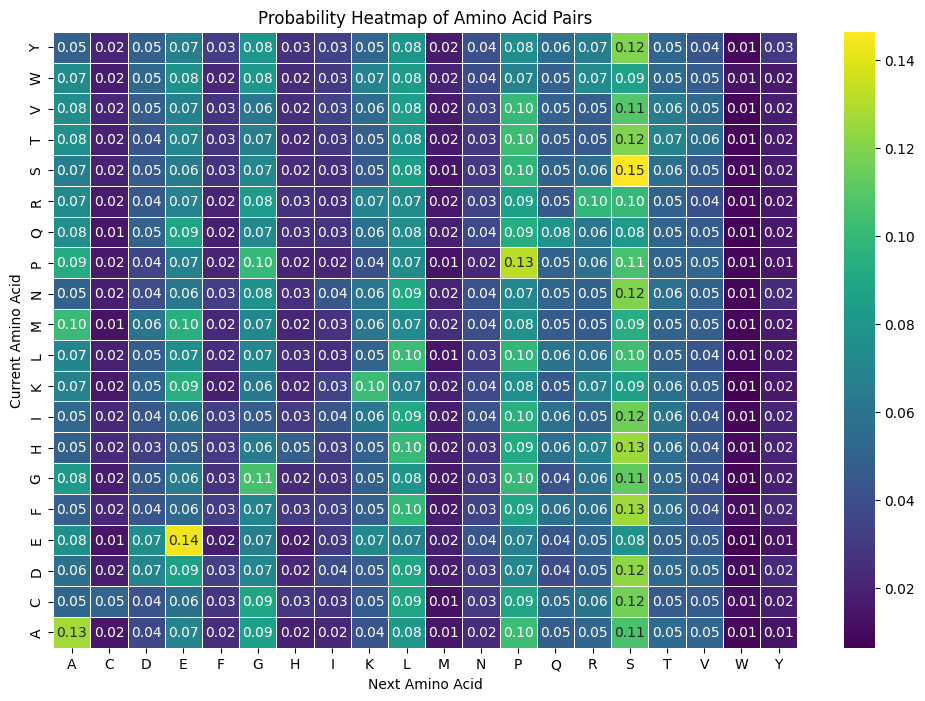

In [62]:
plt.figure(figsize=(12, 8))  # Adjust size as needed
ax = sns.heatmap(df_pair_probabilities, annot=True, fmt=".2f", cmap='viridis', cbar=True, linewidths=.5)
plt.title('Probability Heatmap of Amino Acid Pairs')
plt.xlabel('Next Amino Acid')
plt.ylabel('Current Amino Acid')

# Invert the y-axis to have the first amino acid at the bottom
ax.invert_yaxis()

plt.show()


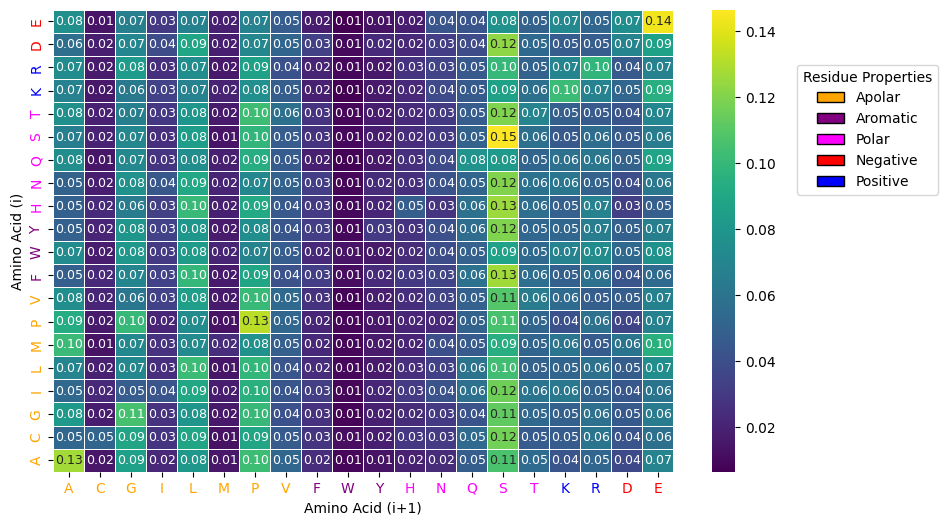

In [39]:
from matplotlib.patches import Patch

# Define the properties of amino acids
def assign_properties_for_heatmap(residue):
    global properties_
    
    properties = {
        'negative': ['E', 'D'],
        'positive': ['R', 'K'],
        'aromatic':['Y','F','W'],
        'apolar': ['A',  'I', 'L', 'M', 'V', 'P', 'G', 'C'],
        'polar': ['S', 'T', 'Q', 'N', 'H']
    }
    properties_ = properties
    colors = {
        'negative': 'red',
        'positive': 'blue',
        'aromatic': 'purple',
        'apolar': 'orange',
        'polar': 'magenta'
    }
    for prop, residues in properties.items():
        if residue in residues:
            return colors[prop]
    return 'black'  # Default color

# Create a mapping of amino acids to group numbers based on properties
property_order = {
    'negative': 5,
    'positive': 4,
    'apolar': 1,
    'aromatic': 2,
    'polar': 3
}
group_mapping = {res: prop for prop, residues in {
        'negative': ['E', 'D'],
        'positive': ['R', 'K'],
        'aromatic':['Y','F','W'],
        'apolar': ['A',  'I', 'L', 'M', 'V', 'P', 'G', 'C'],
        'polar': ['S', 'T', 'Q', 'N', 'H']
    }.items() for res in residues}
group_order = {res: property_order[group] for res, group in group_mapping.items()}

# Sort the DataFrame according to the property groups
sorted_indices = sorted(df_pair_probabilities.columns, key=lambda x: (group_order.get(x, 0), x))
df_sorted = df_pair_probabilities.loc[sorted_indices, sorted_indices]

# Create the heatmap
plt.figure(figsize=(10, 6))
ax = sns.heatmap(df_sorted, annot=True, fmt=".2f", cmap='viridis', cbar=True, linewidths=.5, annot_kws={'size': 9})

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_color(assign_properties_for_heatmap(label.get_text()))

# Invert the y-axis
ax.invert_yaxis()

# Creating custom legend for the properties
legend_elements = [
    Patch(facecolor='orange', edgecolor='black', label='Apolar'),
    Patch(facecolor='purple', edgecolor='black', label='Aromatic'),
    Patch(facecolor='magenta', edgecolor='black', label='Polar'),
    Patch(facecolor='red', edgecolor='black', label='Negative'),
    Patch(facecolor='blue', edgecolor='black', label='Positive')
]
plt.legend(handles=legend_elements, loc=(1.2, 0.6), title='Residue Properties')

plt.xlabel('Amino Acid (i+1)')
plt.ylabel('Amino Acid (i)')
plt.show()


Text(0, 0.5, 'Frequency')

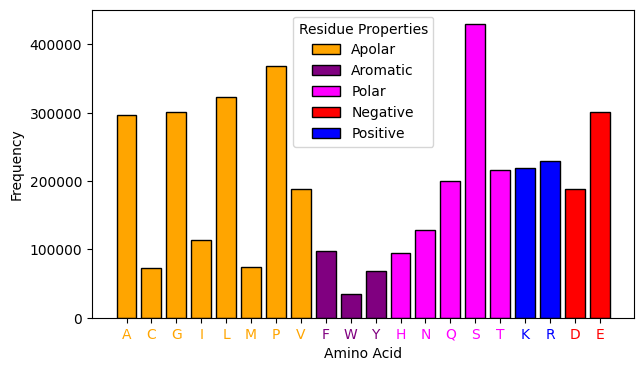

In [35]:
from collections import Counter
# Calculate unique amino acids and their frequencies
amino_acid_counts = Counter()
for seq in all_idrome_seqs:
    amino_acid_counts.update(seq)

aa_for_bar = df_sorted.columns.values

# Sorted list of unique amino acids and their frequencies
frequencies = [amino_acid_counts[aa] for aa in aa_for_bar]

# Plotting the frequencies with colored bars
plt.figure(figsize=(7, 4))
bars = plt.bar(aa_for_bar, frequencies,
               color=[assign_properties_for_heatmap(aa) for aa in aa_for_bar],edgecolor='black')


ax = plt.gca()
for label in ax.get_xticklabels():
    label.set_color(assign_properties_for_heatmap(label.get_text()))

# Creating custom legend for the properties
legend_elements = [
    Patch(facecolor='orange', edgecolor='black', label='Apolar'),
    Patch(facecolor='purple', edgecolor='black', label='Aromatic'),
    Patch(facecolor='magenta', edgecolor='black', label='Polar'),
    Patch(facecolor='red', edgecolor='black', label='Negative'),
    Patch(facecolor='blue', edgecolor='black', label='Positive')
]
plt.legend(handles=legend_elements, loc='upper center', title='Residue Properties')

plt.xlabel('Amino Acid')  
plt.ylabel('Frequency')  



In [64]:
idrome_prop_flucs

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,fI,fL,fM,fN,fQ,fS,fT,fV,fW,fY
0,A0A024RBG1_145_181,A0A024RBG1,37,0.558,10.284649,6.304027,0.933961,0.225950,1.606561,3.843011,...,0.000000,0.108108,0.000000,0.108108,0.027027,0.162162,0.081081,0.081081,0.000000,0.000000
1,A0A075B6T7_1_32,A0A075B6T7,32,0.525,10.092351,6.114494,0.901807,0.212670,1.448141,3.390487,...,0.031250,0.250000,0.062500,0.000000,0.000000,0.062500,0.000000,0.031250,0.062500,0.000000
2,A0A087WTH1_1_67,A0A087WTH1,67,0.532,10.160125,6.069995,0.822738,0.199126,2.243991,5.283533,...,0.074627,0.089552,0.029851,0.014925,0.000000,0.059701,0.029851,0.044776,0.014925,0.000000
3,A0A087WTH5_1_132,A0A087WTH5,132,0.496,10.049124,6.150972,0.798438,0.188978,3.034005,7.119714,...,0.037879,0.106061,0.037879,0.053030,0.045455,0.083333,0.060606,0.068182,0.015152,0.045455
4,A0A087WV53_1_46,A0A087WV53,46,0.567,10.212765,6.439589,0.882210,0.214786,1.882622,4.607908,...,0.065217,0.021739,0.021739,0.021739,0.065217,0.086957,0.021739,0.065217,0.000000,0.021739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28053,Q9Y6Z4_1_181,Q9Y6Z4,181,0.493,10.006512,5.748098,0.799905,0.210890,3.791956,8.607822,...,0.016575,0.055249,0.033149,0.016575,0.038674,0.082873,0.038674,0.071823,0.027624,0.000000
28054,Q9Y6Z5_1_254,Q9Y6Z5,254,0.528,9.830710,6.153759,0.896173,0.221422,4.586832,10.808776,...,0.011811,0.055118,0.023622,0.003937,0.007874,0.102362,0.035433,0.078740,0.062992,0.003937
28055,Q9Y6Z7_1_109,Q9Y6Z7,109,0.546,10.025622,6.175505,0.935857,0.216970,3.011145,7.113405,...,0.073394,0.110092,0.027523,0.027523,0.036697,0.036697,0.036697,0.027523,0.000000,0.000000
28056,W6CW81_1_113,W6CW81,113,0.519,10.084249,6.191149,0.843169,0.193880,2.943990,6.975229,...,0.053097,0.132743,0.017699,0.044248,0.035398,0.123894,0.053097,0.026549,0.008850,0.017699


In [62]:
for aa_uniq in unique_amino_acids_list:
    if aa_uniq!='P':
        idrome_prop_flucs[f'f{aa_uniq}'] = [seq.count(f'{aa_uniq}')/len(seq) for seq in idrome_prop_flucs.fasta.values]


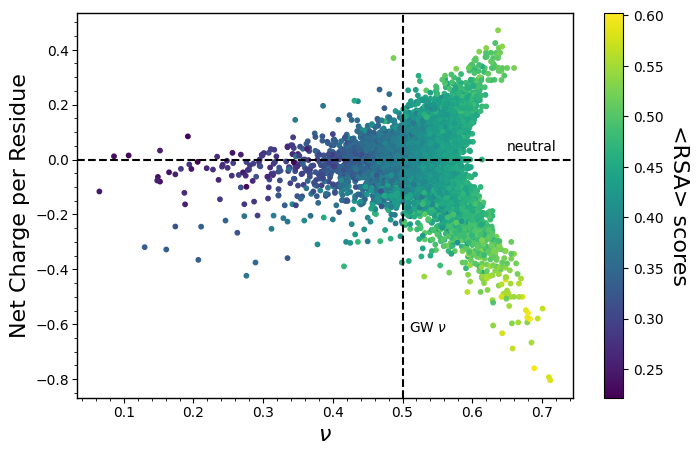

In [70]:
fig, ax = plt.subplots(figsize=(8, 5))

# palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
palette = plt.get_cmap('viridis')

sc = ax.scatter(idrome_prop_flucs['nu'],
           idrome_prop_flucs['net_charge'],c= idrome_prop_flucs['mean_RSA'],cmap=palette,
                s=10)

cbar = plt.colorbar(sc)
cbar.set_label('<RSA> scores',rotation=270,labelpad=18,fontsize=16)

ax.set_xlabel('$\\nu$', fontsize=16)
ax.set_ylabel('Net Charge per Residue', fontsize=16)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.axvline(x=0.5, color='black', linestyle='--')
ax.axhline(y=0.0, color='black', linestyle='--')

ax.text(0.51, 0.2, 'GW $\\nu$', color='black', verticalalignment='top', horizontalalignment='left', transform=ax.get_xaxis_transform())
ax.text(0.65, 0.67, 'neutral', color='black', verticalalignment='top', horizontalalignment='left', transform=ax.get_xaxis_transform())

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width=0.75, pad=2)
ax.tick_params(axis='y', which='minor', width=0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width=0.8, pad=2)
ax.tick_params(axis='x', which='minor', width=0.6)


#plt.savefig('materials_day_physics_presentation/fC_against_NCPR_nu.png', dpi = 1000, bbox_inches='tight')


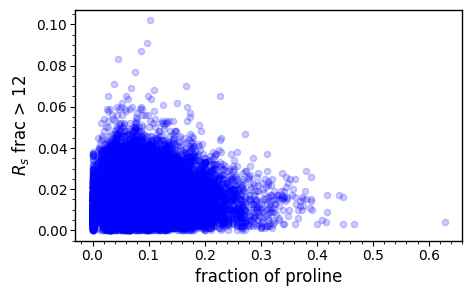

In [144]:
fig,ax = plt.subplots(figsize=(5,3))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')
test_df = idrome_prop_flucs.copy()

sc = ax.scatter(test_df['fP'],test_df['Rs_frac'],s=20,alpha=0.2,
                color='blue')
               
ax.set_xlabel('fraction of proline',fontsize=12)
ax.set_ylabel(r'$R_s$ frac > 12',fontsize=12)
#ax.set_ylim(idrome_prop_flucs.mean_inst_ratio.min(),idrome_prop_flucs.mean_inst_ratio.max())
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)
del test_df

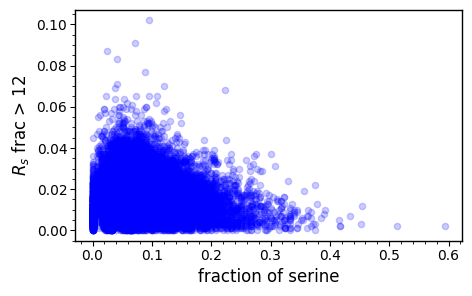

In [65]:
fig,ax = plt.subplots(figsize=(5,3))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')
test_df = idrome_prop_flucs.copy()

sc = ax.scatter(test_df['fA'],test_df['Rs_frac'],s=20,alpha=0.2,
                color='blue')
               
ax.set_xlabel('fraction of serine',fontsize=12)
ax.set_ylabel(r'$R_s$ frac > 12',fontsize=12)
#ax.set_ylim(idrome_prop_flucs.mean_inst_ratio.min(),idrome_prop_flucs.mean_inst_ratio.max())
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)
del test_df

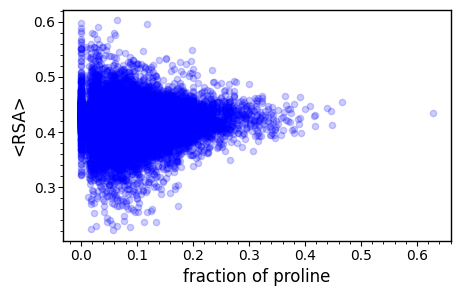

In [58]:
fig,ax = plt.subplots(figsize=(5,3))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')
test_df = idrome_prop_flucs.copy()

sc = ax.scatter(test_df['fP'],test_df['mean_RSA'],s=20,alpha=0.2,
                color='blue')
               
ax.set_xlabel('fraction of proline',fontsize=12)
ax.set_ylabel('<RSA>',fontsize=12)
#ax.set_ylim(idrome_prop_flucs.mean_inst_ratio.min(),idrome_prop_flucs.mean_inst_ratio.max())
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)
del test_df

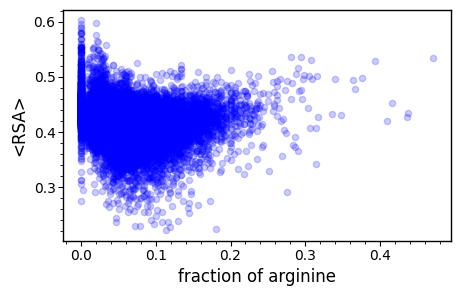

In [72]:
fig,ax = plt.subplots(figsize=(5,3))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')
test_df = idrome_prop_flucs.copy()

sc = ax.scatter(test_df['fR'],test_df['mean_RSA'],s=20,alpha=0.2,
                color='blue')
               
ax.set_xlabel('fraction of arginine',fontsize=12)
ax.set_ylabel('<RSA>',fontsize=12)
#ax.set_ylim(idrome_prop_flucs.mean_inst_ratio.min(),idrome_prop_flucs.mean_inst_ratio.max())
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)
del test_df

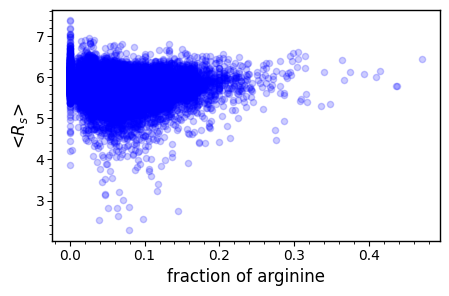

In [78]:
fig,ax = plt.subplots(figsize=(5,3))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')
test_df = idrome_prop_flucs.copy()

sc = ax.scatter(test_df['fR'],test_df['mean_inst_ratio'],s=20,alpha=0.2,
                color='blue')
               
ax.set_xlabel('fraction of arginine',fontsize=12)
ax.set_ylabel(r'<$R_s$>',fontsize=12)
#ax.set_ylim(idrome_prop_flucs.mean_inst_ratio.min(),idrome_prop_flucs.mean_inst_ratio.max())
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)
del test_df

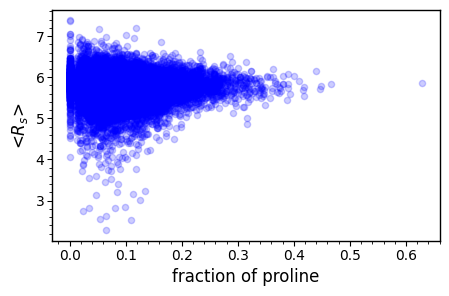

In [79]:
fig,ax = plt.subplots(figsize=(5,3))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')
test_df = idrome_prop_flucs.copy()

sc = ax.scatter(test_df['fP'],test_df['mean_inst_ratio'],s=20,alpha=0.2,
                color='blue')
               
ax.set_xlabel('fraction of proline',fontsize=12)
ax.set_ylabel(r'<$R_s$>',fontsize=12)
#ax.set_ylim(idrome_prop_flucs.mean_inst_ratio.min(),idrome_prop_flucs.mean_inst_ratio.max())
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)
del test_df

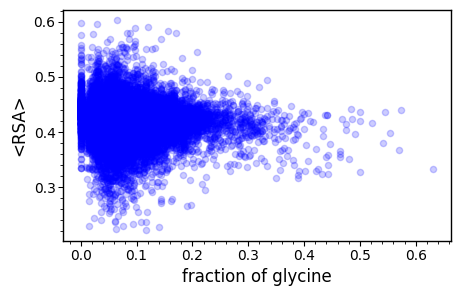

In [69]:
fig,ax = plt.subplots(figsize=(5,3))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')
test_df = idrome_prop_flucs.copy()

sc = ax.scatter(test_df['fG'],test_df['mean_RSA'],s=20,alpha=0.2,
                color='blue')
               
ax.set_xlabel('fraction of glycine',fontsize=12)
ax.set_ylabel('<RSA>',fontsize=12)
#ax.set_ylim(idrome_prop_flucs.mean_inst_ratio.min(),idrome_prop_flucs.mean_inst_ratio.max())
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)
del test_df

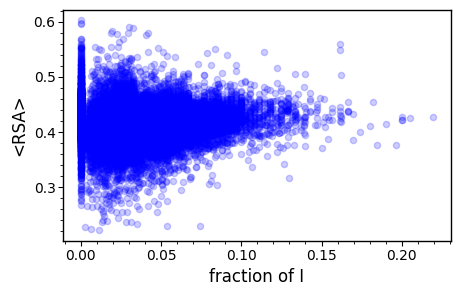

In [71]:
fig,ax = plt.subplots(figsize=(5,3))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')
test_df = idrome_prop_flucs.copy()

sc = ax.scatter(test_df['fI'],test_df['mean_RSA'],s=20,alpha=0.2,
                color='blue')
               
ax.set_xlabel('fraction of I',fontsize=12)
ax.set_ylabel('<RSA>',fontsize=12)
#ax.set_ylim(idrome_prop_flucs.mean_inst_ratio.min(),idrome_prop_flucs.mean_inst_ratio.max())
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)
del test_df

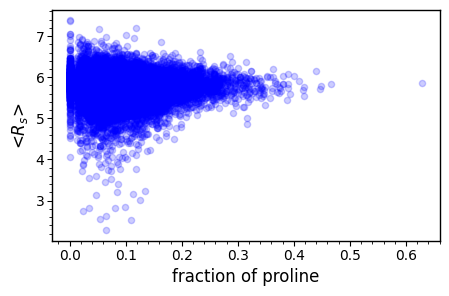

In [145]:
fig,ax = plt.subplots(figsize=(5,3))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')
test_df = idrome_prop_flucs.copy()

sc = ax.scatter(test_df['fP'],test_df['mean_inst_ratio'],s=20,alpha=0.2,
                color='blue')
               
ax.set_xlabel('fraction of proline',fontsize=12)
ax.set_ylabel(r'<$R_s$>',fontsize=12)
#ax.set_ylim(idrome_prop_flucs.mean_inst_ratio.min(),idrome_prop_flucs.mean_inst_ratio.max())
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)
del test_df

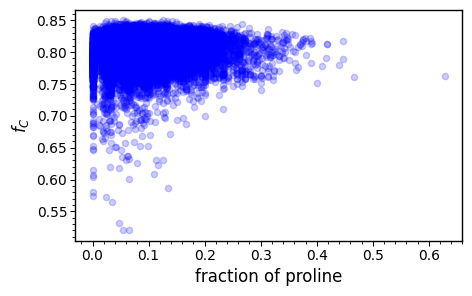

In [146]:
fig,ax = plt.subplots(figsize=(5,3))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')
test_df = idrome_prop_flucs.copy()

sc = ax.scatter(test_df['fP'],test_df['fC_size_shape'],s=20,alpha=0.2,
                color='blue')
               
ax.set_xlabel('fraction of proline',fontsize=12)
ax.set_ylabel(r'$f_C$',fontsize=12)
#ax.set_ylim(idrome_prop_flucs.mean_inst_ratio.min(),idrome_prop_flucs.mean_inst_ratio.max())
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)
del test_df

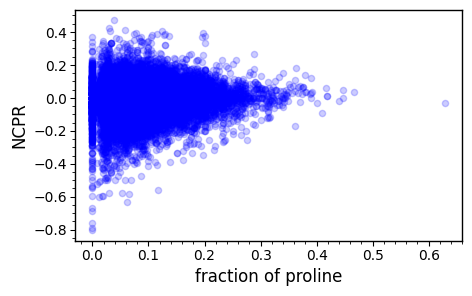

In [147]:
fig,ax = plt.subplots(figsize=(5,3))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')
test_df = idrome_prop_flucs.copy()

sc = ax.scatter(test_df['fP'],test_df['net_charge'],s=20,alpha=0.2,
                color='blue')
               
ax.set_xlabel('fraction of proline',fontsize=12)
ax.set_ylabel('NCPR',fontsize=12)
#ax.set_ylim(idrome_prop_flucs.mean_inst_ratio.min(),idrome_prop_flucs.mean_inst_ratio.max())
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)
del test_df